<a href="https://colab.research.google.com/github/delpretemarcus/156StockClosingPricePrediction/blob/main/DataCleaningAndExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
#Genuinely not sure which of these I use... Will trim as necessary
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from keras.models import Sequential
from keras.optimizers import adam_v2
from keras.utils.vis_utils import plot_model
import math

In [2]:

aplurl = 'https://raw.githubusercontent.com/delpretemarcus/156StockClosingPricePrediction/main/HistoricalQuotes.csv'

df = pd.read_csv(aplurl, index_col='Date')

In [3]:
#Data Cleaning --

df.columns = ['Close', 'Volume', 'Open', 'High', 'Low']
df.index = pd.to_datetime(df.index)
df.sort_index()

df.Close = df.Close.apply(lambda x: x[2:]).astype(np.double)
df.Open = df.Open.apply(lambda x: x[2:]).astype(np.double)
df.High = df.High.apply(lambda x: x[2:]).astype(np.double)
df.Low = df.Low.apply(lambda x: x[2:]).astype(np.double)


df = df.reindex(index=df.index[::-1])


In [4]:
#Scaling
features = ['Open', 'High', 'Low', 'Volume']
scaler = MinMaxScaler()
with_transform = scaler.fit_transform(df[features])
with_transform= pd.DataFrame(columns=features, data=with_transform, index=df.index)
with_transform.head()

,Open,High,Low,Volume
Date,,,,
2010-03-01,0.000000,0.000000,0.003004,0.279219
2010-03-02,0.002022,0.000638,0.004113,0.288472
2010-03-03,0.001543,0.000177,0.004210,0.180643
2010-03-04,0.001707,0.000681,0.004544,0.173428
2010-03-05,0.004445,0.004891,0.007451,0.472832


In [5]:
#Splitting to Training set and Test set
output_var = pd.DataFrame(df['Close'])
timesplit= TimeSeriesSplit(n_splits=5)
for train_index, test_index in timesplit.split(with_transform):
  X_train, X_test = with_transform[:len(train_index)], with_transform[len(train_index): (len(train_index)+len(test_index))]
  y_train, y_test = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()
#Just want the last one out of all the options. Makes life easier


In [6]:
#Process the data for LSTM
trainXnp = np.array(X_train)
testXnp = np.array(X_test)
X_train = trainXnp.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = testXnp.reshape(X_test.shape[0], 1, X_test.shape[1])

In [7]:
#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainXnp.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam', metrics='accuracy')
#plot_model(lstm, show_shapes=True, show_layer_names=True)

In [8]:
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4736      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
_________________________________________________________________


In [9]:
history=lstm.fit(X_train, y_train, epochs=100, batch_size=8, verbose=1, shuffle=False)

Epoch 1/100
263/263 [==============================] - 4s 4ms/step - loss: 10261.0996 - accuracy: 0.0000e+00
Epoch 2/100
263/263 [==============================] - 1s 4ms/step - loss: 9181.8574 - accuracy: 0.0000e+00
Epoch 3/100
263/263 [==============================] - 1s 4ms/step - loss: 7193.9165 - accuracy: 0.0000e+00
Epoch 4/100
263/263 [==============================] - 1s 4ms/step - loss: 4877.2544 - accuracy: 0.0000e+00
Epoch 5/100
263/263 [==============================] - 1s 4ms/step - loss: 2902.6763 - accuracy: 0.0000e+00
Epoch 6/100
263/263 [==============================] - 1s 5ms/step - loss: 1579.3583 - accuracy: 0.0000e+00
Epoch 7/100
263/263 [==============================] - 1s 4ms/step - loss: 870.1743 - accuracy: 0.0000e+00
Epoch 8/100
263/263 [==============================] - 1s 4ms/step - loss: 559.4211 - accuracy: 0.0000e+00
Epoch 9/100
263/263 [==============================] - 1s 4ms/step - loss: 435.8380 - accuracy: 0.0000e+00
Epoch 10/100
263/263 [========

In [13]:
y_pred = lstm.predict(X_test)
train_predict=lstm.predict(X_train)

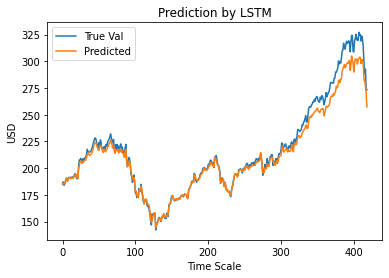

In [11]:
plt.plot(y_test, label='True Val')
plt.plot(y_pred, label='Predicted')
plt.title('Prediction by LSTM')
plt.xlabel('Time Scale')
plt.ylabel('USD')
plt.legend()
plt.show()

In [14]:
### Calculate RMSE performance metrics

math.sqrt(mean_squared_error(y_train,train_predict))

0.9517606442588807

In [15]:
### Test Data RMSE
math.sqrt(mean_squared_error(y_test,y_pred))

7.3881209956372045